<a href="https://colab.research.google.com/github/javanadeem/VYBE/blob/main/ANN_Music_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **##########################   MOOD DETECTION #######################################**

**INSTALLING DEEPFACE**

In [ ]:
!pip install deepface

     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 2.3MB 8.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-cp37-none-any.whl size=9046 sha256=291af4c6dd9f6cf17fd49cd2574d61cddfc703401eb0ae524d1a5eedc86d9133
  Stored in directory: /root/.cache/pip/wheels/ba/fa/c5/12813d7496f34652c43a471e11a780e769889d06e34735c32e
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


**Mood Detection**

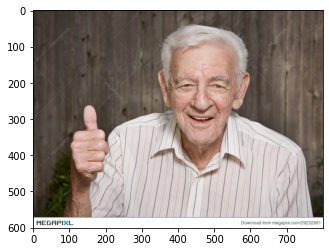

happy


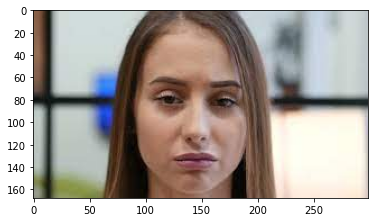

sad

['happy', 'sad']


In [ ]:

from deepface import DeepFace
import matplotlib.pyplot as plt
import cv2
moods=[]
pictures=["/content/drive/MyDrive/Colab Notebooks/Project/old_man.jpg","/content/drive/MyDrive/Colab Notebooks/Project/woman.jpg"]
for i in pictures:
  img1=cv2.imread(i)#converts the image into a numpy array
  plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)) #Converts BGR to RGB color convention
  plt.show()

  result=DeepFace.analyze(img1, actions=['emotion'])
  print(result['dominant_emotion'])
  moods.append(result['dominant_emotion'])
print()
print(moods)

### **##########################   MUSIC CLASSIFICATION #######################################**

**PREPARING THE JSON FILE WITH MFCC VALUES OF 1000 SONGS**

In [ ]:
import json
import os
import math
import librosa

DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/genres"
JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/data_10.json"
SAMPLE_RATE = 22050 #default
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION #number of samples that an entire track comprise of


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
  """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
      :param dataset_path (str): Path to dataset
      :param json_path (str): Path to json file used to save MFCCs
      :param num_mfcc (int): Number of coefficients to extract
      :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
      :param hop_length (int): Sliding window for FFT. Measured in # of samples
      :param: num_segments (int): Number of segments we want to divide sample tracks into
      :return:
      """

  # dictionary to store mapping, labels, and MFCCs
  data = {
      "mapping": [], #contains genres like hiphop, country etc
      "labels": [], #labels the mfcc values relative to the mapping
      "mfcc": []  #contains 13 coefficent values for mfcc
  }

  samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length) # if 1.5 -> 2

  # loop through all genre sub-folder
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)): #os walk is used to traverse the dirpath structure containing multiple dirs n files

    # ensure we're processing a genre sub-folder level 
    if dirpath is not dataset_path:

      # save genre label (i.e., sub-folder name) in the mapping
      semantic_label = dirpath.split("/")[-1] 
      data["mapping"].append(semantic_label) #jazz, country etc
      print("\nProcessing: {}".format(semantic_label))

      # process all audio files in genre sub-dir
      for f in filenames:

        # load audio file
        file_path = os.path.join(dirpath, f) 
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        # process all segments of audio file
        for d in range(num_segments):

          # calculate start and finish sample for current segment
          start = samples_per_segment * d # if d = 0 ; start = 0
          finish = start + samples_per_segment # if d = 0 ; finish = samples_per_segmant

          # extract mfcc (for each segment we will extract its corresponding signal data only)
          mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
          mfcc = mfcc.T #returns numpy array

          # store only mfcc feature with expected number of vectors
          if len(mfcc) == num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(i-1)
            #print("{}, segment:{}".format(file_path, d+1))

  # save MFCCs to json file
  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: country

Processing: metal

Processing: disco

Processing: pop

Processing: reggae

Processing: classical

Processing: rock

Processing: blues

Processing: hiphop

Processing: jazz


**PREDICTION FUNCTION FOR MODEL**

In [ ]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

**CLASSIFICATION MODEL**

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/data_10.json"

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y


if __name__ == "__main__":

    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # build network topology
    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu'),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu'),

        # 3rd dense layer
        keras.layers.Dense(64, activation='relu'),

        # output layer
        keras.layers.Dense(10, activation='softmax')
    ])

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    #model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

    # test model
    test_loss, test_acc = model.evaluate(X_test,y_test)
    
    
    print('test_acc: ',test_acc)
    #print('test_loss: ',test_loss)
    
    

Data succesfully loaded!
Epoch 1/50
219/219 [==============================] - 6s 26ms/step - loss: 8.6258 - accuracy: 0.3141 - val_loss: 3.2015 - val_accuracy: 0.3448
Epoch 2/50
219/219 [==============================] - 6s 26ms/step - loss: 2.2631 - accuracy: 0.3409 - val_loss: 2.1021 - val_accuracy: 0.2861
Epoch 3/50
219/219 [==============================] - 6s 28ms/step - loss: 1.7812 - accuracy: 0.3742 - val_loss: 1.9713 - val_accuracy: 0.3531
Epoch 4/50
219/219 [==============================] - 6s 28ms/step - loss: 1.6096 - accuracy: 0.4169 - val_loss: 1.9137 - val_accuracy: 0.3581
Epoch 5/50
219/219 [==============================] - 6s 27ms/step - loss: 1.4657 - accuracy: 0.4685 - val_loss: 1.9651 - val_accuracy: 0.3938
Epoch 6/50
219/219 [==============================] - 6s 26ms/step - loss: 1.3832 - accuracy: 0.4906 - val_loss: 1.8869 - val_accuracy: 0.4151
Epoch 7/50
219/219 [==============================] - 7s 30ms/step - loss: 1.3080 - accuracy: 0.5168 - val_loss: 1.81

**MODEL TESTING**

In [ ]:
#Model testing
X_to_predict = X_test[110]
y_to_predict = y_test[110]

print(X_test[0])
    # predict sample
predict(model, X_to_predict, y_to_predict)


[[-1.49860870e+02  1.55985931e+02 -1.51561327e+01 ... -6.03787124e-01
   1.08307734e+01 -3.11044502e+00]
 [-1.23712166e+02  1.79227554e+02 -1.44524536e+01 ...  1.03953004e-01
   1.47059288e+01  1.74173057e+00]
 [-1.04352348e+02  1.88348541e+02 -9.66240692e+00 ...  5.60278368e+00
   1.73954391e+01 -7.86564052e-01]
 ...
 [-9.92681961e+01  1.53615143e+02 -1.18636703e+01 ... -7.09896183e+00
  -2.01948476e+00 -6.81641054e+00]
 [-7.43635712e+01  1.61691513e+02 -1.70556488e+01 ... -5.34601212e+00
   5.82725430e+00 -1.52689600e+00]
 [-5.06152000e+01  1.53015930e+02 -1.67579098e+01 ...  4.50363445e+00
   1.06692762e+01  1.26843655e+00]]
Target: 9, Predicted label: [9]


**PREDICTION FUNCTION FOR OUR INPUT PLAYLIST**

In [ ]:
def modelPredict(model, X):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    #print("Predicted label: {}".format(predicted_index))
    return predicted_index

**PREPARING THE JSON FILE WITH MFCC VALUES OF SONGS FROM OUR PLAYLIST**

In [ ]:
#Our loading data function

DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/random"
JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/test.json"
SAMPLE_RATE = 22050 #default
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION #number of samples that an entire track comprise of


def save_mfcc2(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
      "mapping": ['classical','reggae','dico','pop','hiphop','blues','jazz','metal','rock','country'],
      "path": [], #filepaths
      "mfcc": []  #contains 13 coefficent values for mfcc
    }
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length) # if 1.5 -> 2
        
    dirpath='random/'
    for (dirpath, dirnames, filenames) in os.walk(dataset_path):
        for f in filenames:
            file_path = os.path.join(dirpath, f) 
            signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
            for d in range(num_segments):
                start = samples_per_segment * d # if d = 0 ; start = 0
                finish = start + samples_per_segment # if d = 0 ; finish = samples_per_segmant

          # extract mfcc (for each segment we will extract its corresponding signal data only)
                mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                mfcc = mfcc.T #returns numpy array

          # store only mfcc feature with expected number of vectors
                if len(mfcc) == num_mfcc_vectors_per_segment:
                    data["mfcc"].append(mfcc.tolist())
                    #data['labels'].append(i-1)
                    data["path"].append(file_path)
                    
                    #print("{}, segment:{}".format(file_path, d+1))
        
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

if __name__ == "__main__":
    save_mfcc2(DATASET_PATH, JSON_PATH, num_segments=10)



**PREDICTION FUNCTION FOR SONGS FROM OUR PLAYLIST**

In [ ]:
#For our Predictions data load

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/test.json"

def load_data2(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    pth=np.array(data["path"])
    print("Data succesfully loaded!")

    return  X,pth





**SORTING THE PLAYLIST INTO CATEGORIES**

In [ ]:
import numpy as np
from scipy import stats

import shutil,os



label={ "0": "classical", "1":"reggae", "2": "disco", "3": "pop","4":"hiphop","5":"blues","6":"jazz","7" :"metal","8": "rock","9": "country"}

#Create directory Sorted Playlist (Folder) in Drive 
path="/content/drive/MyDrive/Colab Notebooks/Project/" 
x = "Sorted_Playlist"
folder=path+x
os.mkdir(folder) 

#Create subfolders in  Sorted Playlist 
for i in label:
  subfolder=folder+"/"+label[i]
  os.mkdir(subfolder) 


if __name__ == "__main__":
    X,P = load_data2(DATA_PATH)
    count=0
    print(X.shape)

    lst=[]
    c=0;
    for segments in X:
        
        num=modelPredict(model, segments)
        lst.append(num[0])
        
        count =count+1
        if count ==10:
            fp=P[c]
            l=(max(set(lst), key = lst.count))
            l=str(l)
            
            print('song completed :',label[l])
            song_desti=folder+"/"+label[l]
            shutil.copy(fp, song_desti)

            lst=[]
            count=0    
        c=c+1 


Data succesfully loaded!
(340, 130, 13)
song completed : metal
song completed : metal
song completed : metal
song completed : metal
song completed : metal
song completed : metal
song completed : metal
song completed : blues
song completed : blues
song completed : blues
song completed : disco
song completed : disco
song completed : disco
song completed : disco
song completed : disco
song completed : disco
song completed : disco
song completed : country
song completed : country
song completed : country
song completed : country
song completed : reggae
song completed : reggae
song completed : reggae
song completed : reggae
song completed : reggae
song completed : pop
song completed : pop
song completed : hiphop
song completed : hiphop
song completed : jazz
song completed : jazz
song completed : jazz
song completed : jazz


**RECOMMENDING SONGS FROM OUR PLAYLIST BASED ON THE DETECTED MOOD**

In [ ]:
import random
import shutil,os
from os import listdir
import IPython.display as ipd


label={ "happy": ["hiphop","disco","pop","reggae"], "sad":["blues","classical","country"], "neutral": ["jazz"],"angry":["metal","rock"]}

for mood in moods:
  
  mood_category=mood
  size=len(label[mood_category])
  traversed=[]
  file_count=0


  while file_count==0 and len(traversed)!= len(label[mood_category]):
    n = random.randint(0,size-1)
    if n in traversed:
      continue
  
    song_category=n
    selected_category=label[mood_category][song_category]
    #print(selected_category)

    selected_category_folder=folder+"/"+selected_category
    #print(selected_category_folder)
   
    for path, dirs, files in os.walk(selected_category_folder):
      file_count = len(files)
    #path, dirs, files = next(os.walk(selected_category_folder))
    #file_count = len(files)
  
    traversed.append(n) 
  
  print("Mood : ",mood_category)
  print("Selected Genre : ",selected_category)


  if (file_count==0):
    print("Now Playing : none found")
  
  elif (file_count!=0):


    n = random.randint(0,file_count-1)

    song_num=n
    song_list=listdir(selected_category_folder)
    song=song_list[song_num]
 

    import IPython.display as ipd
    songpath=selected_category_folder+"/"+song
    #print(songpath)
    print("Now Playing : ",song)
    ipd.Audio(songpath)



Mood :  happy
Selected Genre :  disco
Now Playing :  disco.00009.wav
Mood :  sad
Selected Genre :  blues
Now Playing :  classical.00008.wav


In [ ]:
mood_category=moods[0]
size=len(label[mood_category])
traversed=[]
file_count=0


while file_count==0 and len(traversed)!= len(label[mood_category]):
  n = random.randint(0,size-1)
  if n in traversed:
    continue
  
  song_category=n
  selected_category=label[mood_category][song_category]
    #print(selected_category)

  selected_category_folder=folder+"/"+selected_category
    #print(selected_category_folder)
   
  for path, dirs, files in os.walk(selected_category_folder):
    file_count = len(files)
    #path, dirs, files = next(os.walk(selected_category_folder))
    #file_count = len(files)
  
  traversed.append(n) 
  
print("Mood : ",mood_category)
print("Selected Genre : ",selected_category)

if (file_count==0):
  print("Now Playing : none found")
  
elif (file_count!=0):


    n = random.randint(0,file_count-1)

    song_num=n
    song_list=listdir(selected_category_folder)
    song=song_list[song_num]
 

    import IPython.display as ipd
    songpath=selected_category_folder+"/"+song
    #print(songpath)
    print("Now Playing : ",song)
    

ipd.Audio(songpath)

Mood :  happy
Selected Genre :  disco
Now Playing :  disco.00004.wav
